### В данном ноутбуке содержатся реализации следующих гипотез:
Одна нормальная выборка, дисперсия известна, односторонняя или двусторонняя альтернатива. Простая vs. сложная гипотезы.

* модификация гипотезы $H_0$

* метод Линдли

* априор с атомом

In [82]:
import numpy as np
import scipy.stats as sps

from collections import namedtuple
from tqdm import tqdm_notebook

from matplotlib import pyplot as plt

### Одна нормальная выборка, дисперсия известна.
### I. Гипотеза: простая vs. сложная, модификация $H_0$.

Дано: 

1) Выборка $X_1, ..., X_n \sim \mathcal{N}(\theta, \sigma^2)$, $\sigma^2$ известна.

2) Априорное распределение $q_{pr} \sim \mathcal{N}(t_0, \sigma_{pr}^2)$.

---------

Тестируется гипотеза: $H_0: \theta = t_0 ~vs~ H_1: \theta \neq t_0$.

Наблюдение: значения в окрестности $t_0$ с практической точки зрения не отличаются от $t_0$.

Модифицируем гипотезу: $H_0^{'}: \theta \in \Theta_0 = (t_0 - \epsilon, t_0 + \epsilon) ~vs~ H_1^{'}: \theta \notin \Theta_0$.

Апостериорное распределение: $\theta | X \sim \mathcal{N}(t_{post}, \sigma_{post}^2)$, где:

* $\Large t_{post} = \frac{\frac{\sum\limits_{i=1}^n X_i}{\sigma^2} + \frac{t_0}{\sigma_{pr}^2}}{\frac{n}{\sigma^2} + \frac{1}{\sigma_{pr}^2}} = ~[$В нашем случае $\sigma = \sigma_{pr}$ $\Large ] ~= \frac{\sum\limits_{i=1}^n X_i + t_0}{n + 1}$

* $\Large \sigma_{post}^2 = \frac{1}{\frac{n}{\sigma^2} + \frac{1}{\sigma_{pr}^2}} = ~[$ В нашем случае $\sigma = \sigma_{pr} $ $\Large ] ~= \frac{\sigma^2}{n + 1}$

Байесовский фактор вычисляется как $\Large B = \frac{p_0\pi_1}{p_1\pi_0}$, где:

* $\pi_0, \pi_1 ~-$ априорные вероятности соответствующих гипотез.

* $p_0, p_1 ~-$ апостериорные вероятности соответствующих гипотез.

In [116]:
import numpy as np
import scipy.stats as sps

from collections import namedtuple

def normal_test_known_var_modification(x, t_pr, sigma, eps=0.05, alternative='two-sided'):
    """ 
    Parameters
    ----------
    x: numpy array
        Array of samples, should be one-dimensional.  
    t_pr : float
        prior loc parameter
    sigma : positive float
        prior std  parameter
    eps : positive float 
        width of null hypothesis
    alternative : 'less', 'two-sided', или 'greater'
        тип тестируемой гипотезы

    Returns
    -------
    t_post : float
    sigma_post : float
    B : float
    """
    
    assert len(x.shape) == 1
    
    n = x.shape[0]
    
    # Априорное распределение
    distr_pr = sps.norm(loc=t_pr, scale=sigma)
    
    # Параметры апостериорного распределения 
    t_post = (x.sum() + t_pr) / (n + 1)
    sigma_post = sigma / ((n + 1) ** 0.5)
    
    # Апостериорное распределение
    distr_post = sps.norm(loc=t_post, scale=sigma_post)
    
    # Априорные и апостериорные вероятности гипотез
    pi_0 = distr_pr.cdf(t_pr + eps) - distr_pr.cdf(t_pr - eps)
    p_0 = distr_post.cdf(t_pr + eps) - distr_post.cdf(t_pr - eps)
    
    # Вычисляем вероятности в зависимости от альтернативы
    if alternative == 'less':
        pi_1 = distr_pr.cdf(t_pr - eps)
        p_1 = distr_post.cdf(t_pr - eps)
    elif alternative == 'greater':
        pi_1 = distr_pr.sf(t_pr + eps)
        p_1 = distr_post.sf(t_pr + eps)    
    elif alternative == 'two-sided':
        pi_1 = 1 - pi_0
        p_1 = 1 - p_0
    else:
        raise Exception("Unknown alternative")
    
    # Нормируем вероятности
    pi_sum = pi_0 + pi_1
    p_sum = p_0 + p_1
    
    pi_0 /= pi_sum
    pi_1 /= pi_sum
    p_0 /= p_sum
    p_1 /= p_sum

    # Вычисляем байесовский фактор
    B = (p_0 * pi_1) / (p_1 * pi_0)
    
    return namedtuple('test_result', ('t_post', 'sigma_post', 'B'))(t_post, sigma_post, B)

---

##### Тесты

---

$X_1, ..., X_{100} \sim \mathcal{N}(0, 1)$

$H_0: t_0 = 0$

Чем больше $\epsilon$, тем больше байесовский фактор при справедливости нулевой гипотезы.

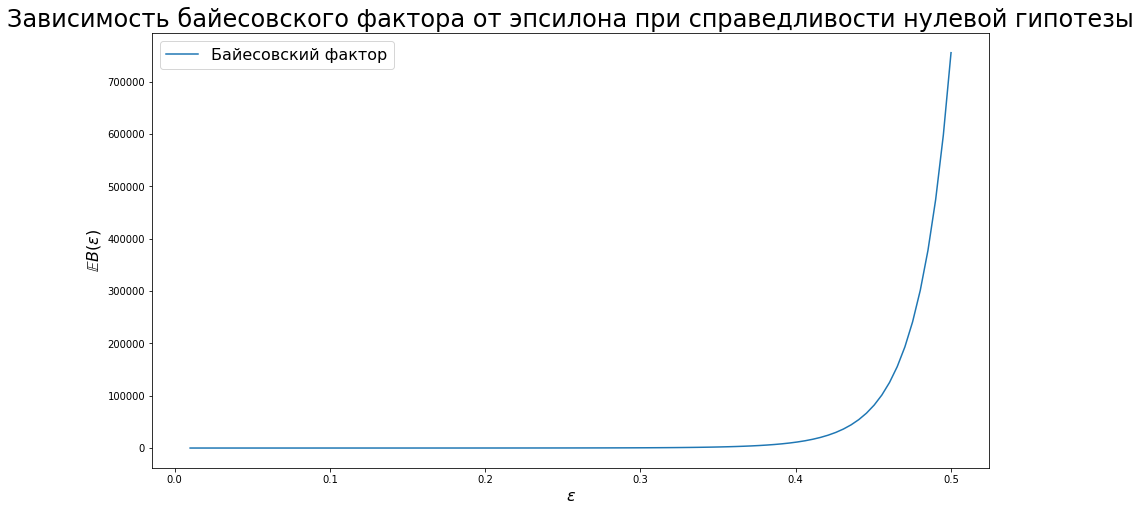

In [93]:
x = sps.norm(0, 1).rvs((1000, 100))

eps = np.linspace(0.01, 0.5, 100)

B = []

for e in tqdm_notebook(eps):
    B.append(np.mean([normal_test_known_var_modification(x[i], 0, 1, eps=e).B  for i in range(1000)]))

plt.figure(figsize=(15, 8))
plt.plot(eps, B, label='Байесовский фактор')
plt.title('Зависимость байесовского фактора от эпсилона при справедливости нулевой гипотезы', fontsize=24)
plt.legend(fontsize=16)
plt.xlabel('$\epsilon$', fontsize=16)
plt.ylabel('$\mathbb{E}B(\epsilon)$', fontsize=16)
plt.show()

---

$H_0: \theta = 0$

$\epsilon = 0.1$

Чем ближе $\theta$ к 0, тем байесовский фактор больше. 

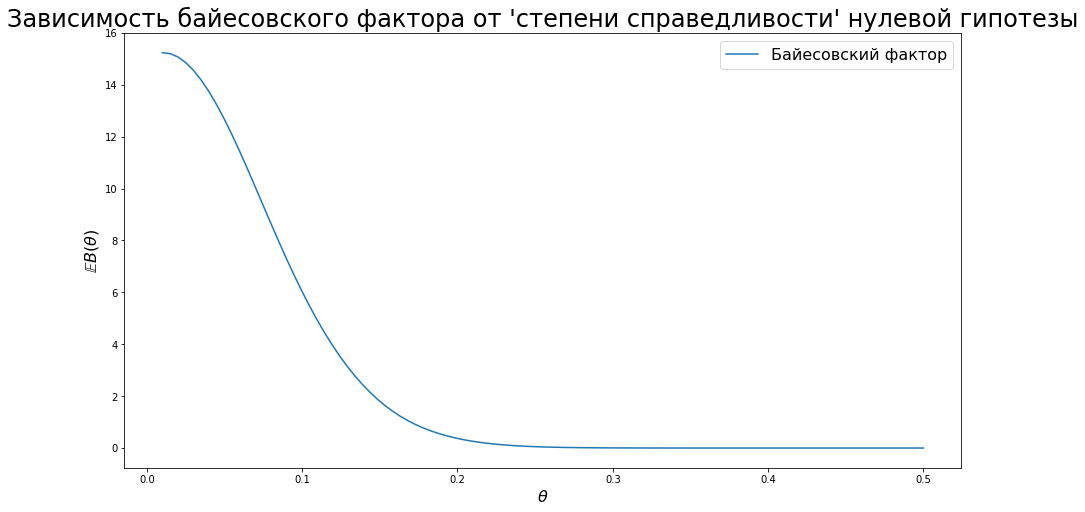

In [102]:
x = sps.norm(0, 1).rvs((1000, 100))

t = np.linspace(0, 1, 100)

B = []

for i in tqdm_notebook(range(len(t))):
    B.append(np.mean([normal_test_known_var_modification(t[i] + x[j], 0, 1, eps=0.1).B  for j in range(1000)]))

plt.figure(figsize=(15, 8))
plt.plot(eps, B, label='Байесовский фактор')
plt.title('Зависимость байесовского фактора от \'степени справедливости\' нулевой гипотезы', fontsize=24)
plt.legend(fontsize=16)
plt.xlabel('$\\theta$', fontsize=16)
plt.ylabel('$\mathbb{E}B(\\theta)$', fontsize=16)
plt.show()

---

$H_0: \theta = 0$

$\epsilon = 0.05$

Если $\theta > 0$, то байесовский фактор при альтернативе $H_1: \theta > 0$ должен быть меньше же, чем при альтернативе $\theta \neq 0$.

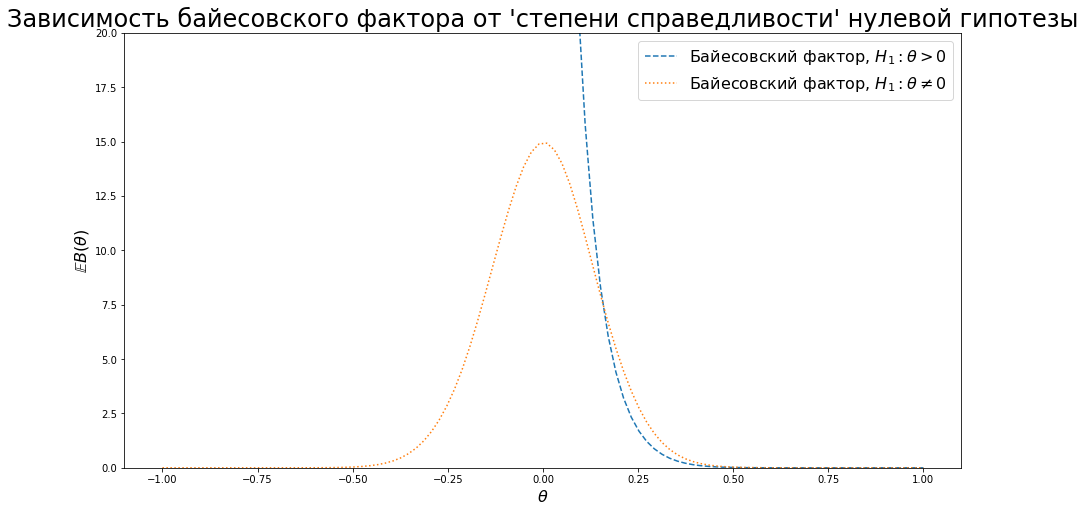

In [122]:
x = sps.norm(0, 1).rvs((1000, 100))

t = np.linspace(-1, 1, 100)

B_greater = []
B_all = []

for i in tqdm_notebook(range(len(t))):
    B_greater.append(np.mean([normal_test_known_var_modification(t[i] + x[j], 0, 1, eps=0.1, alternative='greater').B  
                      for j in range(1000)]))
    B_all.append(np.mean([normal_test_known_var_modification(t[i] + x[j], 0, 1, eps=0.1, alternative='two-sided').B  
                      for j in range(1000)]))

plt.figure(figsize=(15, 8))
plt.plot(t, B_greater, '--', label='Байесовский фактор, $H_1: \\theta > 0$')
plt.plot(t, B_all, ':', label='Байесовский фактор, $H_1: \\theta \\neq 0$')
plt.title('Зависимость байесовского фактора от \'степени справедливости\' нулевой гипотезы', fontsize=24)
plt.legend(fontsize=16)
plt.xlabel('$\\theta$', fontsize=16)
plt.ylabel('$\mathbb{E}B(\\theta)$', fontsize=16)
plt.ylim((0, 20))
plt.show()

### II. Гипотеза: простая vs. сложная, метод Линдли.

### III. Гипотеза: простая vs. сложная, априор с атомом.